# References
1. [xgboost-python](https://blog.quantinsti.com/xgboost-python)
2. [prophet-py](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
3. [LSTM](https://colab.research.google.com/github/google-coral/tutorials/blob/master/train_lstm_timeseries_ptq_tf2.ipynb)

# Data Preparation

In [ ]:
!pip install --upgrade pandas-datareader 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 25.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


## Imports

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn
# For data manipulation
import pandas as pd
import numpy as np
import json 
import requests
from datetime import date


## Fetch stocks

## Peek into yahoo data

In [ ]:
# Set the stock list
stock_list = ['AAPL', 'GOOG', 'AMZN', 'META']
# Set the start date and the end date
start_date = '2016-11-29'
end_date = date.today().strftime("%Y-%m-%d")
#end_date = '2022-11-30'

In [ ]:
# Get the data    
df = data.get_data_yahoo(stock_list[0], start_date, end_date)
df.tail(1)

Attributes   Adj Close                                     Close              \
Symbols           AAPL        GOOG  AMZN        META        AAPL        GOOG   
Date                                                                           
2022-12-01  148.309998  101.279999  95.5  120.440002  148.309998  101.279999   

Attributes                          High              ...        Low  \
Symbols     AMZN        META        AAPL        GOOG  ...       AMZN   
Date                                                  ...              
2022-12-01  95.5  120.440002  149.130005  102.586899  ...  94.921898   

Attributes                    Open                                     \
Symbols           META        AAPL        GOOG       AMZN        META   
Date                                                                    
2022-12-01  118.410004  148.210007  101.400002  96.989998  119.197998   

Attributes      Volume                                      
Symbols           AAPL        GOOG        AMZN        META  
Date                                                        
2022-12-01  71250416.0  21771536.0  68487969.0  35549741.0  

[1 rows x 24 columns]

In [ ]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    # Get the data    
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    df['daily_volume_change'] = df['Volume'].pct_change()

    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_price_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_price_'+str(r)] = df.daily_pct_change.rolling(r).std()
        df['pct_change_volume'+str(r)] = df.daily_volume_change.rolling(r).sum()
        df['std_volume_'+str(r)] = df.daily_volume_change.rolling(r).std()
        predictor_list.append('pct_change_price_'+str(r))
        predictor_list.append('std_price_'+str(r))
        predictor_list.append('pct_change_volume'+str(r))
        predictor_list.append('std_volume_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    # drop empty values
    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df}) 
  
    list_of_column_names = list(df.columns) 

In [ ]:
list_of_column_names

['High',
 'Low',
 'Open',
 'Close',
 'Volume',
 'Adj Close',
 'daily_pct_change',
 'daily_volume_change',
 'pct_change_price_10',
 'std_price_10',
 'pct_change_volume10',
 'std_volume_10',
 'pct_change_price_15',
 'std_price_15',
 'pct_change_volume15',
 'std_volume_15',
 'pct_change_price_20',
 'std_price_20',
 'pct_change_volume20',
 'std_volume_20',
 'pct_change_price_25',
 'std_price_25',
 'pct_change_volume25',
 'std_volume_25',
 'pct_change_price_30',
 'std_price_30',
 'pct_change_volume30',
 'std_volume_30',
 'pct_change_price_35',
 'std_price_35',
 'pct_change_volume35',
 'std_volume_35',
 'pct_change_price_40',
 'std_price_40',
 'pct_change_volume40',
 'std_volume_40',
 'pct_change_price_45',
 'std_price_45',
 'pct_change_volume45',
 'std_volume_45',
 'pct_change_price_50',
 'std_price_50',
 'pct_change_volume50',
 'std_volume_50',
 'pct_change_price_55',
 'std_price_55',
 'pct_change_volume55',
 'std_volume_55',
 'return_next_day',
 'actual_signal']

In [ ]:
df.shape[1]

50

In [ ]:
df.tail(3)


,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,daily_volume_change,pct_change_price_10,std_price_10,...,pct_change_price_50,std_price_50,pct_change_volume50,std_volume_50,pct_change_price_55,std_price_55,pct_change_volume55,std_volume_55,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-28,112.040001,108.379997,110.779999,108.779999,23309400,108.779999,-0.023607,0.941221,-0.036549,0.018903,...,-0.235082,0.047353,3.361662,0.462019,-0.375211,0.046736,4.258955,0.456614,0.006251,1
2022-11-29,110.940002,108.540001,109.540001,109.459999,23899200,109.459999,0.006251,0.025303,-0.040915,0.018584,...,-0.240656,0.047320,3.834424,0.456070,-0.367836,0.046763,4.232933,0.456655,0.078933,1
2022-11-30,118.160004,109.379997,109.510002,118.099998,43274700,118.099998,0.078933,0.810718,0.012978,0.031380,...,-0.148685,0.048759,4.597874,0.467696,-0.195213,0.046609,4.129640,0.453350,0.019814,1


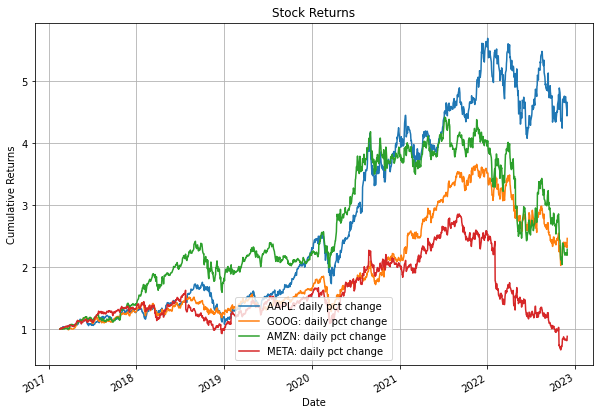

In [ ]:

# Set the figure size
plt.figure(figsize=(10, 7))
# Access the dataframe of stocks from the dictionary 
# and then compute and plot the returns
for stock_name in stock_list:
  (stock_data_dictionary[stock_name].daily_pct_change+1).cumprod().plot(label=stock_name+ ": daily pct change")
  # (stock_data_dictionary[stock_name].daily_volume_change+1).plot(label=stock_name+ ": daily Volume")

# Set the title and axis labels and plot grid
plt.title('Stock Returns')
plt.ylabel('Cumulative Returns')
plt.legend(loc='lower center')
plt.grid()
plt.show()

## Prepare train and test data

In [ ]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series('float64')
y_test = pd.Series('float64')
for stock_name in stock_list:
  # Get predictor variables
  X = stock_data_dictionary[stock_name][predictor_list]
  # Get the target variable
  y = stock_data_dictionary[stock_name].actual_signal
# Divide the dataset into train and test
  train_length = int(len(X)*0.80)
  X_train = X_train.append(X[:train_length])
  X_test = X_test.append(X[train_length:])
  y_train = y_train.append(y[:train_length])
  y_test = y_test.append(y[train_length:])

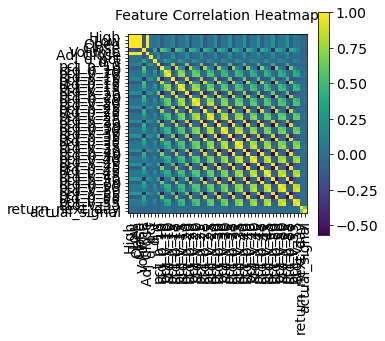

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

# XGBoost experiment

In [ ]:
from xgboost import XGBClassifier, plot_importance

In [ ]:
# Initialize the model and set the hyperparameter values
xgbc_model = XGBClassifier(max_depth=5, 
                      n_estimators=13, 
                      learning_rate=0.05, 
                      reg_alpha=0.55, 
                      max_delta_step=5, 
                      gamma=0.01, 
                      alpha=0.01)
xgbc_model

XGBClassifier(alpha=0.01, gamma=0.01, learning_rate=0.05, max_delta_step=5,
              max_depth=5, n_estimators=13, reg_alpha=0.55)

In [ ]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=None)
# Perform K-Fold Cross Validation
results = cross_val_score(xgbc_model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 53.54% (1.43%)


In [ ]:
xgbc_model.fit(X_train, y_train)


XGBClassifier(alpha=0.01, gamma=0.01, learning_rate=0.05, max_delta_step=5,
              max_depth=5, n_estimators=13, reg_alpha=0.55)

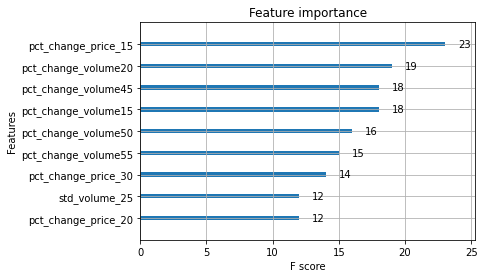

In [ ]:
# Plot the top 7 features
plot_importance(xgbc_model, max_num_features=9)
# Show the plot
plt.show()

In [ ]:
# Predict the trading signal on test dataset
y_pred = xgbc_model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.56      0.17      0.26       600
           1       0.49      0.86      0.63       568

    accuracy                           0.51      1168
   macro avg       0.53      0.51      0.45      1168
weighted avg       0.53      0.51      0.44      1168



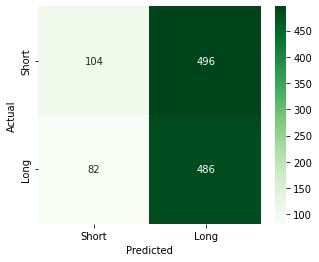

In [ ]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AAPL


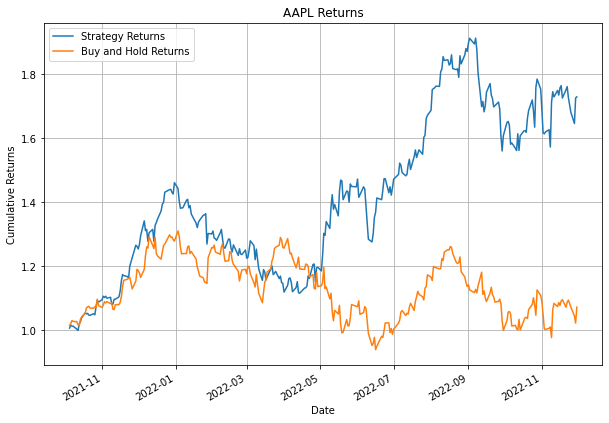

GOOG


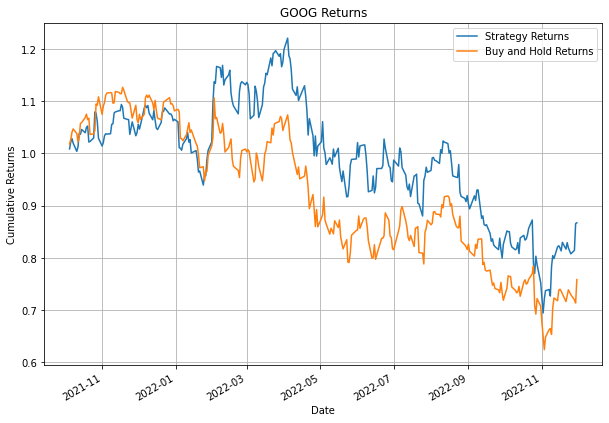

AMZN


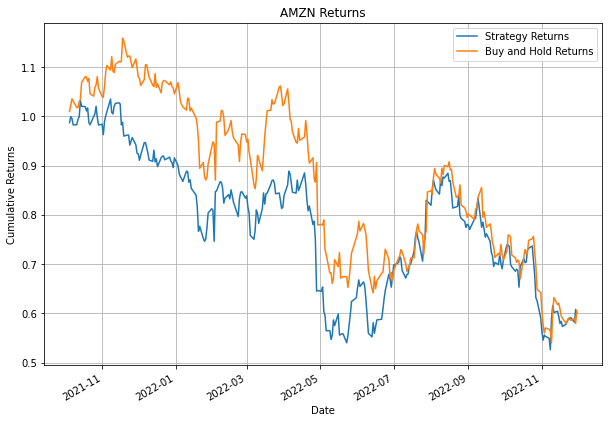

META


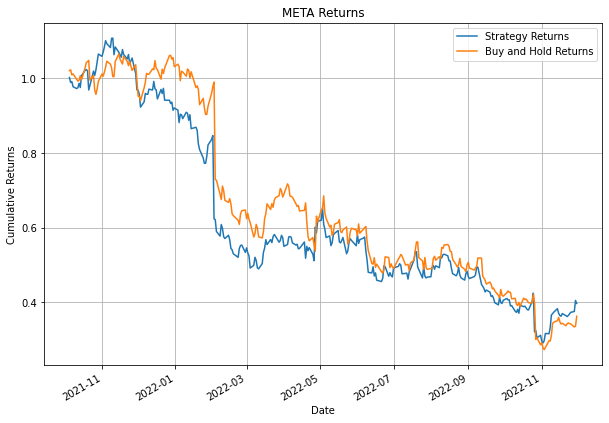

In [ ]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
  # Get the data
  df = stock_data_dictionary[stock_name]
  # Store the predictor variables in X
  X = df[predictor_list]  
  # Define the train and test dataset
  train_length = int(len(X)*0.80)
  # Predict the signal and store in predicted signal column
  df['predicted_signal'] = xgbc_model.predict(X)
  # Calculate the strategy returns
  df['strategy_returns'] = df.return_next_day * df.predicted_signal
  # Add the strategy returns to the portfolio dataframe
  portfolio[stock_name] = df.strategy_returns[train_length:]
  # Plot the stock strategy and buy and hold returns
  print(stock_name)
  # Set the figure size
  plt.figure(figsize=(10, 7))
  # Calculate the cumulative strategy returns and plot
  (df.strategy_returns[train_length:]+1).cumprod().plot()
  # Calculate the cumulative buy and hold strategy returns
  (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
  # Set the title, label and grid
  plt.title(stock_name + ' Returns')
  plt.ylabel('Cumulative Returns')
  plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
  plt.grid()
  plt.show()

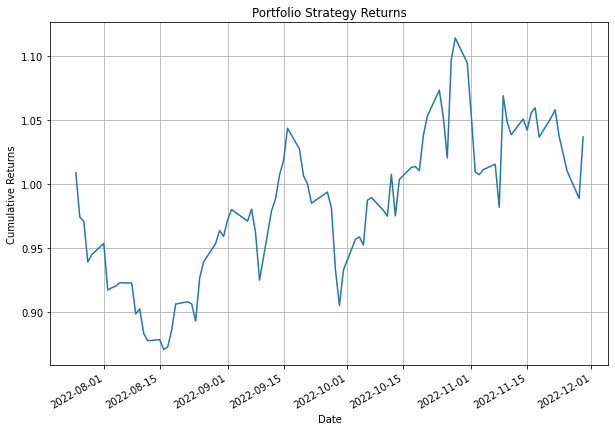

In [ ]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [ ]:
portfolio.shape

(292, 4)

In [ ]:
portfolio.tail(5)

,AAPL,GOOG,AMZN,META
Date,,,,
2022-11-22,0.005926,-0.015309,0.009979,-0.007179
2022-11-23,-0.019594,-0.012346,0.007649,0.007395
2022-11-25,-0.026264,-0.013832,0.005781,0.023607
2022-11-28,-0.021148,0.008416,-0.016285,-0.006251
2022-11-29,0.048594,0.062971,0.044579,-0.078933


In [ ]:
!pip install pyfolio --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))

Start date,2021-10-04
End date,2022-11-29
Total months,13
,Backtest
Annual return,-21.8%
Cumulative returns,-24.7%
Annual volatility,32.3%
Sharpe ratio,-0.60
Calmar ratio,-0.51
Stability,0.72
Max drawdown,-42.4%


AttributeError: ignored

In [ ]:
data.get_sector_performance_av().head()

ValueError: ignored

Prophet

In [ ]:
from prophet import Prophet

In [ ]:
p_df = pd.DataFrame()
p_df = pd.DataFrame(index=X_train.index.copy())
p_df.index.names = ['ds']
print(list(X_train.columns))
index = p_df.index
print(index)
p_df['y'] = X_train.pct_change_10
p_df['ds'] = index 
print(list(p_df.columns))
# print(X_train.loc["Date"].tail)
#p_df["ds"] = pd.to_datetime(X_train.loc[:,'Date'],format= '%H:%M:%S' ).dt.time


prophet = Prophet()
prophet.fit(p_df)


['pct_change_price_10', 'std_price_10', 'pct_change_volume10', 'std_volume_10', 'pct_change_price_15', 'std_price_15', 'pct_change_volume15', 'std_volume_15', 'pct_change_price_20', 'std_price_20', 'pct_change_volume20', 'std_volume_20', 'pct_change_price_25', 'std_price_25', 'pct_change_volume25', 'std_volume_25', 'pct_change_price_30', 'std_price_30', 'pct_change_volume30', 'std_volume_30', 'pct_change_price_35', 'std_price_35', 'pct_change_volume35', 'std_volume_35', 'pct_change_price_40', 'std_price_40', 'pct_change_volume40', 'std_volume_40', 'pct_change_price_45', 'std_price_45', 'pct_change_volume45', 'std_volume_45', 'pct_change_price_50', 'std_price_50', 'pct_change_volume50', 'std_volume_50', 'pct_change_price_55', 'std_price_55', 'pct_change_volume55', 'std_volume_55']
DatetimeIndex(['2017-02-17', '2017-02-21', '2017-02-22', '2017-02-23',
               '2017-02-24', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03',
               ...
     

AttributeError: ignored

In [ ]:
future = prophet.make_future_dataframe(periods=135)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = prophet.plot(forecast)

NameError: ignored